<a href="https://colab.research.google.com/github/finedominos/synthetised-speech-dataset/blob/master/Dataset_Creation_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and the dataset

In [ ]:
import numpy as np
from pathlib import Path
import random
import shutil
import IPython
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd

In [ ]:
# variable to choose if we import the test-clean set as well
import_test_clean = True

In [ ]:
import tarfile
if not os.path.isdir("LibriSpeech"):
  # Getting the .tar.gz file from LibriSpeech ("dev-clean" set from https://www.openslr.org/12)
  !wget https://www.openslr.org/resources/12/dev-clean.tar.gz
  tar = tarfile.open("dev-clean.tar.gz")
  tar.extractall()
  tar.close()
  !rm dev-clean.tar.gz

  if import_test_clean: # getting the test subset
    !wget https://www.openslr.org/resources/12/test-clean.tar.gz
    tar_test = tarfile.open("test-clean.tar.gz")
    tar_test.extractall()
    tar_test.close()
    !rm test-clean.tar.gz

else:
  print("LibriSpeech already downloaded :)")

--2021-06-23 04:12:15--  https://www.openslr.org/resources/12/dev-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application/x-gzip]
Saving to: ‘dev-clean.tar.gz’

dev-clean.tar.gz    100%[===================>] 322.27M  27.8MB/s    in 12s     

2021-06-23 04:12:28 (26.4 MB/s) - ‘dev-clean.tar.gz’ saved [337926286/337926286]

--2021-06-23 04:12:31--  https://www.openslr.org/resources/12/test-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346663984 (331M) [application/x-gzip]
Saving to: ‘test-clean.tar.gz’

test-clean.tar.gz   100%[===================>] 330.60M  27.8MB/s    in 13s     

2021-06-23 04:12:44 (25.6 MB/s) - ‘test-clean.tar.gz’ saved [346

# Functions

## Chapters information extraction

In [ ]:
def get_chapters_info():
  """
  Reading the file CHAPTERS.TXT, in which the data is organized as:
  ID|READER|MINUTES|SUBSET|PROJ.|BOOK ID|CH. TITLE|PROJECT TITLE (Book title)
  Returns:
    chapters_info: List with the information about chapters coming from the chosen subset "dev-clean"
  """


  chapters_file = open("LibriSpeech/CHAPTERS.TXT") # Open the text file containing info about all chapters
  chapters_info_all = chapters_file.readlines()
  chapters_info_all = chapters_info_all[14:]        # Remove the first several lines with just text (kinda readme)

  # Only extracting the chapters info from the dev-clean subset
  chapters_info = [] 
  for item in chapters_info_all:
    subset = item.split("| ")[3]
    if "dev-clean" in subset: # Not using equivallence (==) because of spaces in the string
      chapters_info.append(item)

  if import_test_clean:
    for item in chapters_info_all:
      subset = item.split("| ")[3]
      if "test-clean" in subset: # Not using equivallence (==) because of spaces in the string
        chapters_info.append(item)


  #print("Number of chapters in the whole LibriSpeech dataset:", len(chapters_info_all))
  print("Number of chapters in the chosen subset of chapters 'dev-clean' and 'test-clean':", len(chapters_info))

  return chapters_info

## Books published year extraction

In [ ]:
def get_published_years(chaptersInfo, debugModeOn = False):
  """
  Searching for the books' published year.
  Going through the information about chapters from "dev-clean", extracting lists.
  Parameters:
    chaptersInfo: Extracted information about chapters
  Returns:
    chapters_table: The list of chapters IDs from the list chapters_info, the corresponding books' published years, and the book titles
    books_table: The list of book titles and corresponding published years (only different books)
  """

  chapters_table = []
  books_table = []
  
  prev_book_id = None

  url = r"https://www.googleapis.com/books/v1/volumes" # TODO: find what is this volumes in the url?

  for i in range(len(chaptersInfo)):
    chapter_id = chaptersInfo[i].split("| ")[0]
    if debugModeOn:
      print("Line no.", i)
      print("Chapter ID ", chapter_id)
    book_id = chaptersInfo[i].split("| ")[5]
    book_title = chaptersInfo[i].split("| ")[7]

    # Do the query only when a new book is examined
    # (Since several chapters refer to the same book)
    
    if (prev_book_id != book_id):
      year_found = False    # For keeping track if the info about the published year is accessible
      #print("New query starting for book ID: ", book_id)

      # Building the query
      book_query = "intitle:" + book_title
      params = {"q": book_query}
      response = requests.get(url, params = params)
      response_dict = response.json()
      if "items" in response_dict:
        response_all_results = response_dict["items"]
  # For eventual debugging 
  #    else:
  #      print("No key named items in the dictionary")
      
      # Exploring all results found for the chosen book
      
      result_year_earliest = 2021  # The earliest found year: initialized to today
      
      for result in response_all_results:
        if "volumeInfo" in result:
          result_info = result["volumeInfo"]
          if "publishedDate" in result_info:   # If there is information about the published date
            result_year_str = result_info["publishedDate"]
            if (result_year_str[:4].isdigit()):  # If the published date string can be converted to a digit
              result_year = int(result_year_str[:4])
              year_found = True

              # If the currently examined book is earlier than the earliest found so far
              if (result_year < result_year_earliest):
                result_year_earliest = result_year
      
      if year_found == True: # If the published year successfully found, add it to the list of years
        books_table.append([book_title, int(result_year_earliest)])
                      

  # For eventual debugging      
  #          else:
  #            print("The found published date is not a digit")    
  #        else:
  #          print("No key named publishedDate in the dictionary")        
  #      else:
  #        print("No key named volumeInfo in the dictionary")"""
                
              
    if year_found == True: # If the published year successfully found, add it to the list of years
      chapters_table.append([chapter_id, int(result_year_earliest), book_title])
      if debugModeOn:
        print("Earliest found published year of the book '", book_title,"': ", result_year_earliest, "\n")
    else:
      print("No info found about the published year of the book '", book_title[:-1], "\n")
      
    prev_book_id = book_id

  chapters_table = np.asarray(chapters_table)
  books_table = np.asarray(books_table)

  for ch in chapters_table:
    ch_title = (ch[2])[:-1]
    ch[2] = ch_title
    ch_id = int(ch[0])
    ch[0] = ch_id

  for b in books_table:
    b_title = (b[0])[:-1]
    b[0] = b_title
  
  if debugModeOn:
    print("Number of different books in the chosen subset of chapters:", len(books_table))
    print("\n")

  return chapters_table, books_table

## Filtering the dataset according to the published year data

In [ ]:
def filter_by_years(chaptersTable, yearMin=1800, debugModeOn=False):
  """
  The function filter_by_years filters the dataset of chapters according to the published year data
  Parameters:
    chaptersTable (2D array) - the list of chapters information to be filtered (chapters ID, published year, book title)
    yearMin - the earliest published year to consider
    debugModeOn
  Returns:
    chaptersTableFilter
  """
  chaptersTableFilter = []

  for i in range(len(chaptersTable[:,0])):
    if (int(chaptersTable[i,1]) > yearMin):
      chaptersTableFilter.append(chaptersTable[i])
    elif debugModeOn:
      print("Deleted chapter with the ID no. ", chapters_table[i,0])
        
  print("\nNumber of chapters in the original subset:", len(chaptersTable))
  print("Number of chapters in the filtered subset:", len(chaptersTableFilter))
 
  chaptersTableFilter = np.asarray(chaptersTableFilter)
  
  return chaptersTableFilter

## Extracting the lines of text from the chapters

In [ ]:
# Extract the lines from the text files of chapters

def extract_lines(chaptersPaths, chaptersTable):
  
  content_lines = []
  chaptersIDs = list(map(int, chaptersTable[:,0])) # Extract only the list of chapter IDs
  # print(chaptersIDs)

  for i, file in enumerate(chaptersPaths):
    chapter_id = int(file.split("/")[3])

    # If the current chapter belongs to the list of considered chapters
    if (chapter_id in chaptersIDs):
      f = open(file, "r")                 # Open each file to read it
      content = f.readlines()             # Read all lines into a list
      for line in content:                # Iterate through each line in a list. example of line: "1919-142785-0063 ILLUSTRATION SAGE\n"
        string = line.split('\n')[-2]     # Remove the "\n" from lines
        string = string.split(' ', 1)     # Split the string after the first space, keep both parts. example of result: ['1919-142785-0063', 'ILLUSTRATION SAGE']
        content_lines.append(string)      # Add the extracted strings to the list of lines


  print("Number of lines after filtering:", len(content_lines))

  return np.asarray(content_lines)
  

## Filtering sentences with non-standard words (according to NLTK)

In [ ]:
import nltk
nltk.download('words')
nltk.download('wordnet')
# Basic vocabulary dictionary:
english_vocab = set(w.upper() for w in nltk.corpus.words.words())

# Lemmatizer:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
# Adding all country names: (We estimate countries are common language)
!pip install pycountry
import pycountry
countries = []
for country in pycountry.countries:
  countries += (country.name.upper().split(" ")[:])
  countries.append('ENGLAND') # Because of uk it's not in...

# Other frequent common words still not in english_vocab
other_allowed_exceptions = ["OTHERS", "LONDON", "SYDNEY", "EUROPE", 'FAVOUR', 'FAVOURABLE', 'FAVOURITE'] # what about SAVOUR, VAPOUR,... would also be an issue for speech to text, so I'd say no... but, what about americans versions...

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 10.1MB 203kB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=a3689e92ca2acea6e1976387e5f2eef33bcc5cdb50dac8f76996663dca7a54e3
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


### Dictionary of contractions

In [ ]:
contractions_dict = { 
# "ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
# "can't've": "cannot have",
# "'cause": "because",
"could've": "could have",
"couldn't": "could not",
# "couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
# "hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
# "he'd've": "he would have",
"he'll": "he shall / he will",
# "he'll've": "he shall have / he will have",
"he's": "he has / he is",
# "how'd": "how did",
# "how'd'y": "how do you",
# "how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
# "I'd've": "I would have",
"I'll": "I shall / I will",
# "I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
# "it'd've": "it would have",
"it'll": "it shall / it will",
# "it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
# "ma'am": "madam",
# "mayn't": "may not",
# "might've": "might have",
# "mightn't": "might not",
# "mightn't've": "might not have",
# "must've": "must have",
"mustn't": "must not",
# "mustn't've": "must not have",
# "needn't": "need not",
# "needn't've": "need not have",
"o'clock": "of the clock",
# "oughtn't": "ought not",
# "oughtn't've": "ought not have",
# "shan't": "shall not",
# "sha'n't": "shall not",
# "shan't've": "shall not have",
"she'd": "she had / she would",
# "she'd've": "she would have",
"she'll": "she shall / she will",
# "she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
# "shouldn't've": "should not have",
# "so've": "so have",
# "so's": "so as / so is",
"that'd": "that would / that had",
# "that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
# "there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
# "they'd've": "they would have",
"they'll": "they shall / they will",
# "they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
# "to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
# "we'd've": "we would have",
"we'll": "we will",
# "we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
# "what'll've": "what shall have / what will have",
# "what're": "what are",
# "what's": "what has / what is",
# "what've": "what have",
# "when's": "when has / when is",
# "when've": "when have",
# "where'd": "where did",
# "where's": "where has / where is",
# "where've": "where have",
# "who'll": "who shall / who will",
# "who'll've": "who shall have / who will have",
# "who's": "who has / who is",
# "who've": "who have",
# "why's": "why has / why is",
# "why've": "why have",
# "will've": "will have",
"won't": "will not",
# "won't've": "will not have",
# "would've": "would have",
"wouldn't": "would not",
# "wouldn't've": "would not have",
"y'all": "you all",
# "y'all'd": "you all would",
# "y'all'd've": "you all would have",
# "y'all're": "you all are",
# "y'all've": "you all have",
"you'd": "you had / you would",
# "you'd've": "you would have",
"you'll": "you shall / you will",
# "you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_upper_list = [string.upper() for string in contractions_dict.keys()]

### Actual function

In [ ]:
KEEP_CONTRACTIONS = True

def filter_non_existing_words(sentences_list, debugModeOn=False):
  """ Filters the list of sentences discard the ones with unexisting words 
  in NLTK's dictionary

  :param sentences_list: list of sentences [sentence_id, uppercase_sentence]
  :returns: filtered list of sentences, same format
  """
  number_true = 0
  number_false = 0
  number_countries = 0
  number_contractions = 0
  number_exceptions = 0
  word_count = 0    # Just checkin'
  list_false = []
  filtered_dataset = []
  for i,sentence in enumerate(sentences_list[:,1]):
    flag = True
    for word in sentence.split(" "):
      word_count += 1
      if word in english_vocab:
        number_true += 1
      elif lemmatizer.lemmatize(word.lower(), 'n').upper() in english_vocab:   # Plural is also not included in english_vocab, so lemmatizing to singular
        number_true += 1 
      elif lemmatizer.lemmatize(word.lower(), 'v').upper() in english_vocab:  # Conjugated verbs as well / past participal
        number_true += 1 
      elif lemmatizer.lemmatize(word.lower(), 'a').upper() in english_vocab:  # Comparative and Superlative
        number_true += 1 
      # elif lemmatizer.lemmatize(word.lower(), 's').upper() in english_vocab:  # Superlative
      #   print("sattelite: ", word)
      #   number_true += 1 
      # elif lemmatizer.lemmatize(word.lower(), 'r').upper() in english_vocab:  # Adverbs
      #   print("adverbs: ", word)
      #   number_true += 1 
      elif word in countries:  # Comparative and Superlative
        number_true += 1 
        number_countries += 1
      elif word in contractions_upper_list and KEEP_CONTRACTIONS:  # I'm, won't, shouldn't, etc...
        number_true += 1 
        number_contractions += 1
      elif word in other_allowed_exceptions and KEEP_CONTRACTIONS:  # I'm, won't, shouldn't, etc...
        number_true += 1 
        number_exceptions += 1
      elif word[-2:]=="'S": # Possessive
        if word[:-2] in english_vocab:
          number_true += 1
        else:
          flag = False
          number_false += 1
          list_false.append((word[:-2], sentence))
      else:
        flag = False
        number_false += 1
        list_false.append((word, sentence))
  
    if flag:
      filtered_dataset.append(sentences_list[i][:])

  if debugModeOn:
    print("Total number of words words: ",word_count)
    print("Number of existing words: ",number_true)
    print("Number of unexisting words: ",number_false)
    print("Number of countries: ",number_countries)
    print("Number of contractions: ",number_contractions)
    print("Number of other exceptions: ",number_exceptions)

  return np.asarray(filtered_dataset)


## Words counter

In [ ]:
#counter words

def words_counter(string):
  word_list = []
  word_list = string.split(" ")
  n_word = len(word_list)
  return n_word

In [ ]:
# Count the words 

def count_words(contentLines, debugModeOn=False):
  lengths=[] #array with lengths of each sentece in the dataset
  for s in contentLines:
    sentence_len=words_counter(s[1])
    lengths.append(sentence_len)

  len_arr=np.asarray(lengths)
  lengths=np.expand_dims(len_arr,1)

  mean_len=np.mean(lengths)
  max_len=np.max(lengths)
  min_len=np.min(lengths)
  arg_min=np.argmin(lengths)
  arg_max=np.argmax(lengths)

  if debugModeOn:
    print("The mean is %f" %mean_len)
    print("The max is %d at indice %d" %(max_len, arg_max))
    print("The sentence is")
    print(contentLines[arg_max][1])
    print("The min is %d at indice %d" %(min_len, arg_min))
    print("The sentence is")
    print(contentLines[arg_min][1])

  #histogram of the whole dataset

  plt.figure(figsize = (10,6))
  bins=np.arange(min_len,max_len)
  a=plt.hist(lengths, bins=bins)  # arguments are passed to np.histogram
  plt.title("Lenghts of lines in the LibriSpeech corpus")
  plt.xlabel("Number of words in a line")
  plt.ylabel("Number of lines")
  plt.xlim(0)
  plt.show()

  if debugModeOn:
    print("Sentences with same lenghts (from %d to %d)" %(min_len,max_len))
    print(a[0])

  #reduction of the dataset

  arg_sort=np.argsort(lengths,axis=0)
  sort_length=np.reshape(lengths[arg_sort],(lengths[arg_sort].shape[0],1)) #sort the lengths in order from the sentence with less words
  sort_dataset = np.reshape(contentLines[arg_sort],(contentLines[arg_sort].shape[0],2)) #sort the dataset in order from the sentence with less words
  left=int(lengths.shape[0]*0.1) #to reduce from less words
  right=-int(lengths.shape[0]*0.3) #to reduce from more words
  short_dataset=sort_dataset[left:right,:] #reduce the dataset
  new_lengths=sort_length[left:right,:]

  #another histogram
  
  min2=np.min(new_lengths)
  max2=np.max(new_lengths)

  bins2=np.arange(min2,max2)
  b=plt.hist(new_lengths, bins=bins2)  # arguments are passed to np.histogram
  plt.title("Histogram of new lengths")
  plt.show()

  print("Kept sentences with lengths between %d and %d"%(min2, max2))

  if debugModeOn:
    print("Sentences with same lenghts (from %d to %d)" %(min2,max2))
    print(b[0])

  return short_dataset


# Main

## Parameters

In [ ]:
# Parameters

published_year_minimum = 1850     # Earliest published date to consider
debug_mode_on = False             # Functions will print outputs if the debug mode is on

## Extracting data

In [ ]:
chapters_info = get_chapters_info()

Number of chapters in the chosen subset of chapters 'dev-clean' and 'test-clean': 184


In [ ]:
chapters_table, books_table = get_published_years(chapters_info, debug_mode_on)

In [ ]:
# chapters_table is organized as: [chapter_id, book_year, book_title]
# books_table is organized as: [book_title, book_year]

print(chapters_table.shape)
print("Example line of chapters_table: ",chapters_table[2])
print("Example line of books_table: ", books_table[2])

print("Number of different books: ", len(books_table))

(184, 3)
Example line of chapters_table:  ['8226' '1869' 'He Knew He Was Right']
Example line of books_table:  ['Hypatia' '1753']
Number of different books:  117


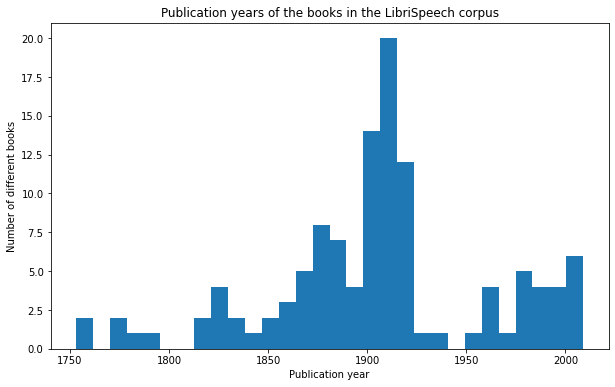

In [ ]:
# Histogram

plt.figure(figsize = (10,6))
plt.hist(list(map(int, books_table[:,1])), bins = 30)
#plt.axvline(x=published_year_minimum, color='k', linestyle='--') # Plotting the published year threshold
plt.title("Publication years of the books in the LibriSpeech corpus")
plt.xlabel("Publication year")
plt.ylabel("Number of different books")
plt.show()

In [ ]:
# Getting the list of chapters (text files)
chapters_paths = [str(file) for file in Path().glob("LibriSpeech/dev-clean/*/*/*.trans.txt")]
if import_test_clean:
  chapters_paths_test = [str(file) for file in Path().glob("LibriSpeech/test-clean/*/*/*.trans.txt")]
  chapters_paths = chapters_paths + chapters_paths_test

print(len(chapters_paths))

184


## Filtering chapters list

In [ ]:
chapters_table_filtered = filter_by_years(chapters_table, published_year_minimum)


Number of chapters in the original subset: 184
Number of chapters in the filtered subset: 160


In [ ]:
print("Example line of chapters_table_filtered: ", chapters_table_filtered[0])

Example line of chapters_table_filtered:  ['4943' '1878' 'For the Term of His Natural Life']


In [ ]:
"""
Extracting lines from chapters into the list content_lines (array with 2 columns):
The first column is with indexes (speaker-chapter-line, example "1919-142785-0063")
The second column is with strings corresponding to lines (example "ILLUSTRATION SAGE")
"""
content_lines = extract_lines(chapters_paths, chapters_table_filtered)

Number of lines after filtering: 4694


In [ ]:
print("\nExample first column of the 1st element of content_lines:\n", content_lines[0,0])
print("Example second column of the 2nd element of content_lines:\n", content_lines[0,1])


Example first column of the 1st element of content_lines:
 2086-149214-0000
Example second column of the 2nd element of content_lines:
 THE NARRATIVE IT MAY BE IS WOVEN OF SO HUMBLE A TEXTURE AS TO REQUIRE THIS ADVANTAGE AND AT THE SAME TIME TO RENDER IT THE MORE DIFFICULT OF ATTAINMENT


In [ ]:
content_lines_filtered = filter_non_existing_words(content_lines, debug_mode_on)
print("Number of lines after filtering non-existing words:", len(content_lines_filtered))


# If filtering non-existing words from the original dataset, it reduces from 2703 to 2151 lines
# If filtering from the dataset filtered by years, it reduces from 2367 to 1868 lines

Number of lines after filtering non-existing words: 3710


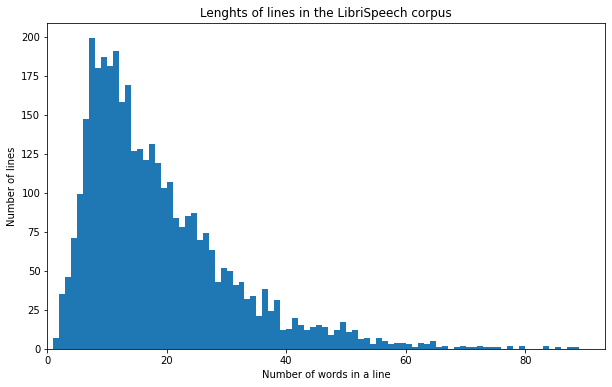

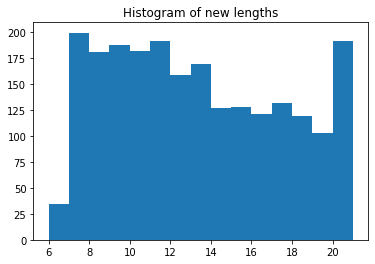

Kept sentences with lengths between 6 and 22
Number of lines after filtering by sentences length: 2226


In [ ]:
content_lines_filtered1 = count_words(content_lines_filtered, debug_mode_on)

print("Number of lines after filtering by sentences length:", len(content_lines_filtered1))

In [ ]:
print(content_lines_filtered1.shape)
print(content_lines_filtered1[1])

(2183, 2)
['4970-29095-0000' 'SHE WAS TIRED OF OTHER THINGS']


## Writing to JSON

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filtered_dataset = (content_lines_filtered1[:,0]).tolist() # keeping only the first column because only lines ID

with open("dataset_dev_test_filters_1850.json", "w") as outfile:
    json.dump(filtered_dataset, outfile, indent=4)  
with open('/content/dataset_dev_test_filters_1850.json', 'w') as f:
    json.dump(filtered_dataset, f, indent=4)

## Opening filtered lists of sentences

In [ ]:
with open("/content/dataset_dev_test_filters_1850.json", "r") as jsonfile:
    data_filters = json.load(jsonfile)

with open("/content/dataset_wer_0.json", "r") as jsonfile:
   data_wer = json.load(jsonfile)


print("Number of lines filtered with 3 filters: ", len(data_filters))
print("Number of lines filtered with WER: ", len(data_wer))

print("\ndata_filters: ", data_filters)
#print("data_wer: ", data_wer)

Number of lines filtered with 3 filters:  2223
Number of lines filtered with WER:  1620

data_filters:  ['8463-294828-0018', '1272-135031-0021', '3752-4943-0027', '4446-2275-0017', '672-122797-0047', '1462-170142-0042', '4446-2271-0023', '1995-1826-0010', '7976-105575-0017', '1995-1826-0008', '8463-294828-0022', '1988-147956-0005', '7976-105575-0020', '4446-2275-0014', '1995-1826-0003', '3729-6852-0025', '7850-286674-0012', '3729-6852-0030', '8463-294828-0025', '5536-43358-0000', '7850-286674-0017', '1995-1826-0004', '7850-73752-0019', '6295-244435-0006', '777-126732-0026', '3752-4944-0019', '3752-4944-0014', '1462-170145-0010', '3752-4943-0017', '6930-75918-0010', '908-157963-0001', '2035-147961-0033', '4446-2275-0027', '672-122797-0010', '121-127105-0009', '3000-15664-0006', '4446-2275-0024', '2035-147961-0022', '4446-2275-0009', '3752-4944-0001', '3000-15664-0026', '4507-16021-0008', '6319-275224-0012', '2035-147961-0015', '2035-147960-0009', '5536-43358-0014', '672-122797-0014', '1

In [ ]:
intersect = []
for sentence in data_filters:
  if sentence in data_wer:
    intersect.append(sentence)
print("length of the intersection:", len(intersect))

length of the intersection: 970


In [ ]:
dict_books = {}

for chapter in chapters_table:
  if chapter[2] not in dict_books.keys():
    dict_books[chapter[2]] = []

for sentence in intersect:
  chapter_code = sentence.split('-')[1]
  flag = False
  for chapter in chapters_table:
    if chapter_code == chapter[0]:
      dict_books[chapter[2]].append(sentence)
      
      flag = True
  if not flag:
    print("ERROR: chapter %s didn't find his book"%chapter)


In [ ]:
print(dict_books)

{'For the Term of His Natural Life': ['3752-4944-0019', '3752-4944-0014', '3752-4944-0001', '3752-4943-0009', '3752-4944-0045', '3752-4944-0043', '3752-4944-0033', '3752-4944-0029', '3752-4944-0006', '3752-4944-0007', '3752-4944-0060', '3752-4944-0054', '3752-4943-0014', '3752-4943-0012', '3752-4944-0009', '3752-4944-0035', '3752-4944-0040', '3752-4944-0042', '3752-4944-0011', '3752-4944-0010', '3752-4943-0008', '3752-4943-0029', '3752-4943-0028', '3752-4944-0002', '3752-4944-0034', '3752-4944-0051', '3752-4943-0020', '3752-4944-0059', '3752-4944-0013', '3752-4944-0039'], 'He Knew He Was Right': ['3536-8226-0027', '3536-8226-0029', '3536-8226-0030'], 'Hypatia': [], 'Steep Trails': ['3000-15664-0006', '3000-15664-0026', '3000-15664-0003', '3000-15664-0004', '3000-15664-0027', '3000-15664-0046'], 'Simple Story': [], 'Waverley, Volume 1': [], "It's Like This, Cat (Version 2)": ['1988-24833-0014', '1988-24833-0028', '1988-24833-0026', '1988-24833-0000', '1988-24833-0008', '1988-24833-0023'

In [ ]:
num_remaining_books = 0
num_sentences_1 = 0
num_sentences_2 = 0
num_sentences_3 = 0
num_sentences_4 = 0 

data = {'book title': [],
        'book year': [],
        'number of sentences': []
        }
for book in dict_books.keys():
  year = 0
  for b in books_table:
    if b[0]==book:
      year = b[1]
      break
  data['book title'].append(book)
  data['book year'].append(year)
  data['number of sentences'].append(len(dict_books[book]))
  if len(dict_books[book]) == 1:
    num_sentences_1 += 1
  if len(dict_books[book]) == 2:
    num_sentences_2 += 1
  if len(dict_books[book]) == 3:
    num_sentences_3 += 1
  if len(dict_books[book]) == 4:
    num_sentences_4 += 1  
  # print('{:>60}  {:>12}  {:>12}'.format(book[:55], year, len(dict_books[book])))
  if len(dict_books[book]) > 0:
    num_remaining_books += 1
print("Total number of different books still having sentences:", num_remaining_books,"/",len(books_table))
df = pd.DataFrame (data, columns = ['book title','book year','number of sentences'])

Total number of different books still having sentences: 93 / 117


In [ ]:
df.sort_values(by=['number of sentences'], ascending=False).style.hide_index()

book title,book year,number of sentences
Commentary on St. Paul's Epistle to the Galatians,1851,38
My Antonia,1918,38
Return of Sherlock Holmes,1905,34
Sister Carrie,1900,34
Alexander's Bridge (version 2),1912,34
Alexander's Bridge (version 3),1912,32
For the Term of His Natural Life,1897,30
Initials Only,1851,27
Amusement Only,1859,26
Man Who Laughs,1888,24


## Extracting the dataset of 300 sentences

In [ ]:
print(num_sentences_4)

7


In [ ]:
dataset_300 = []

#First round - taking one sentence from each book
for i, book in enumerate(df["book title"]):
  if df["number of sentences"][i] > 0:
    #print("\n", book, ", ", df["number of sentences"][i], "sentences")
    #print(dict_books[book])
    rnd_sentence = random.choice(dict_books[book])
    #print("CHOSEN SENTENCE: ", rnd_sentence)
    dataset_300.append(rnd_sentence)


#Second round - taking randomly sentences from books
temp = list(df["book title"].items()) 
chosen_books = []

while len(dataset_300) < 300:
  if len(dataset_300) == num_remaining_books*2 - num_sentences_1 or \
  len(dataset_300) == num_remaining_books*3 - num_sentences_1*2 - num_sentences_2 or \
  len(dataset_300) == num_remaining_books*4 - num_sentences_1*3 - num_sentences_2*2 - num_sentences_3: 
    chosen_books = []
  rnd_book = random.choice(df["book title"])
  index = [idx for idx, key in enumerate(temp) if key[1] == rnd_book]
  num_sentences = df["number of sentences"][index[0]]
  
  if rnd_book not in chosen_books:
    if num_sentences > 1:
      #print("\n", rnd_book, ", ", num_sentences, "sentences")
      #print(dict_books[rnd_book])
      rnd_sentence = random.choice(dict_books[rnd_book])
      if rnd_sentence not in dataset_300:
        #print("CHOSEN SENTENCE: ", rnd_sentence)
        dataset_300.append(rnd_sentence)
        chosen_books.append(rnd_book)
      #else:
        #print("SENTENCE %s IS ALREADY IN THE DATASET"%rnd_sentence)
  #else:
    #print("This book was already chosen once")

print("Length of the final dataset: %d sentences"%len(dataset_300))

Length of the final dataset: 300 sentences


In [ ]:
print("Final dataset of 300 sentences IDs:\n", dataset_300)


Final dataset of 300 sentences IDs:
 ['3752-4944-0006', '3536-8226-0029', '3000-15664-0003', '1988-24833-0023', '5895-34615-0000', '5536-43358-0000', '174-50561-0019', '6319-57405-0007', '6241-61943-0012', '5694-64038-0011', '6295-64301-0014', '6319-64726-0006', '6313-66129-0035', '6241-66616-0020', '7850-73752-0002', '6313-76958-0031', '2428-83699-0030', '174-84280-0011', '7976-105575-0019', '7976-110124-0007', '7976-110523-0016', '251-118436-0018', '84-121550-0015', '422-122949-0029', '777-126732-0078', '1272-128104-0012', '652-129742-0007', '652-130726-0030', '1272-135031-0017', '251-136532-0002', '3170-137482-0032', '251-137823-0016', '1272-141231-0011', '1919-142785-0028', '1993-147964-0006', '2086-149220-0045', '2277-149897-0028', '2035-152373-0003', '2412-153954-0023', '2803-154320-0002', '2803-161169-0011', '3853-163249-0040', '3081-166546-0011', '1462-170142-0015', '6295-244435-0024', '8297-275154-0026', '6319-275224-0009', '5338-284437-0007', '7850-286674-0008', '8842-302201-

In [ ]:
content_lines_300 = []

for sentence_id in dataset_300:
  for i, item in enumerate(content_lines):
    if sentence_id == content_lines[i,0]:
      content_lines_300.append(content_lines[i])

content_lines_300 = np.asarray(content_lines_300)

print("\nExample first column of the 1st element of content_lines_300:\n", content_lines_300[0,0])
print("Example second column of the 2nd element of content_lines_300:\n", content_lines_300[0,1])


Example first column of the 1st element of content_lines_300:
 3752-4944-0006
Example second column of the 2nd element of content_lines_300:
 HAVE YOU MANY VISITORS CAPTAIN BURGESS VERY FEW


In [ ]:
print("Final dataset of 300 sentences in text: \n", content_lines_300[:,1])

Final dataset of 300 sentences in text: 
 ['HAVE YOU MANY VISITORS CAPTAIN BURGESS VERY FEW'
 "I'VE WATCHED AS SHARP AS WATCHING CAN GO PRETTY NEAR"
 'GO QUIETLY ALONE NO HARM WILL BEFALL YOU'
 'TOM SAYS THANKS AND LOOKS AT HILDA AND SHE BLUSHES REALLY'
 'BUT IS LAUGHTER A SYNONYM OF JOY' 'THE SAVAGE PHILOSOPHER THE DUAL MIND'
 'YOU SEE THE TREATMENT IS A TRIFLE FANCIFUL'
 'IS THERE ANYTHING THAT YOU WISH HE ASKED'
 'THE FACT WAS THAT SCARCELY ANY ONE OF THEM BUT EXPECTED SOME GOODS BY THE PERIODICAL VESSEL'
 'BUT HOW TO GET HIM OUT WAS THE UNSOLVED PROBLEM'
 'THEY SAT DOWN AND LISTENED IN SILENCE'
 'HE KNEW THAT SHE WOULD NOT AWAKE FOR A HUNDRED YEARS'
 'AS A RESULT INSTEAD OF STOPPING WHEN HE REACHED THE HAT THE BOY KEPT ON GOING'
 'SPRING CAME AND PASSED AND THEN SUMMER'
 'IT REQUIRES SOME SELF COMMUNION TO PREPARE OURSELVES FOR GOOD FORTUNE AS WELL AS TO ENCOUNTER DIFFICULTY AND DANGER AND DISGRACE'
 'WE HAD BETTER START THE DRIVE THIS MORNING'
 'NO ANSWER THOUGH I ALLOWED A MORE T

In [ ]:
final_dataset = (content_lines_300).tolist()

with open("dataset_300.json", "w") as outfile:
    json.dump(final_dataset, outfile, indent=4)  
with open('/content/dataset_300.json', 'w') as f:
    json.dump(final_dataset, f, indent=4)